In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Путь к файлу CSV
data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv"
train_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv"
test_data_path = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv"

# Чтение данных из CSV-файлов
data = pd.read_csv(data_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [5]:
data = data.rename(columns={'atis_flight': 'intent', ' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning': 'text'})
lost_intent = {'intent': 'atis_flight', 'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'}
data = pd.concat([data, pd.DataFrame([lost_intent])], ignore_index=True)

In [6]:
# Find classes with only one sample
class_counts = data['intent'].value_counts()
single_sample_classes = class_counts[class_counts == 1].index.tolist()

# Separate single sample classes
single_sample_data = data[data['intent'].isin(single_sample_classes)]
multiple_sample_data = data[~data['intent'].isin(single_sample_classes)]

In [7]:
# train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['intent'])
# Perform stratified split on multiple sample data
train_multiple, test_multiple = train_test_split(multiple_sample_data, test_size=0.2, random_state=42, stratify=multiple_sample_data['intent'])

# Add single sample data to both train and test sets to ensure all classes are present
train = pd.concat([train_multiple, single_sample_data]).reset_index(drop=True)
test = pd.concat([test_multiple, single_sample_data]).reset_index(drop=True)

# Ensure no duplicates in train and test sets
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized*100, len(unique_values_normalized), len(unique_values_normalized_test))

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [8]:
# Check for missing classes and ensure all classes are present
train_classes = set(train['intent'])
test_classes = set(test['intent'])
all_classes = set(data['intent'])

# Find missing classes in train and test sets
missing_train_classes = all_classes - train_classes
missing_test_classes = all_classes - test_classes

# Add missing classes examples to train and test sets
if missing_train_classes:
    missing_train_data = data[data['intent'].isin(missing_train_classes)]
    train = pd.concat([train, missing_train_data])
    train = train.drop_duplicates().reset_index(drop=True)

if missing_test_classes:
    missing_test_data = data[data['intent'].isin(missing_test_classes)]
    test = pd.concat([test, missing_test_data])
    test = test.drop_duplicates().reset_index(drop=True)

# Print unique value proportions
unique_values_normalized = train['intent'].value_counts(normalize=True)
unique_values_normalized_test = test['intent'].value_counts(normalize=True)
print(unique_values_normalized * 100, len(unique_values_normalized), len(unique_values_normalized_test)) 

intent
atis_flight                                 73.869079
atis_airfare                                 8.621607
atis_ground_service                          5.082491
atis_airline                                 3.113358
atis_abbreviation                            2.474721
atis_aircraft                                1.676424
atis_flight_time                             1.117616
atis_quantity                                1.091006
atis_distance                                0.425758
atis_flight#atis_airfare                     0.399148
atis_ground_fare                             0.372539
atis_airport                                 0.372539
atis_city                                    0.372539
atis_capacity                                0.345929
atis_flight_no                               0.266099
atis_meal                                    0.133049
atis_restriction                             0.106440
atis_airline#atis_flight_no                  0.053220
atis_ground_service#a

In [9]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Добавление дополнительного измерения
#         print(f'x shape: {x.shape}')
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [11]:
from sklearn.preprocessing import LabelEncoder

# Создание LabelEncoder
le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])

In [12]:
# Токенизация и преобразование в TF-IDF
tokenizer = word_tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer)

train_texts = vectorizer.fit_transform(train['text']).toarray()
test_texts = vectorizer.transform(test['text']).toarray()

# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(torch.from_numpy(train_texts), train_labels)
test_dataset = TextDataset(torch.from_numpy(test_texts), test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_texts.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []


In [14]:
n_epoches = 20

In [15]:
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for i, (texts, labels) in enumerate(tqdm(train_loader)):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(tqdm(test_loader)):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

100%|██████████| 31/31 [00:00<00:00, 325.04it/s]


Epoch 1, Train Loss: 1.73299960463734, Val Loss: 0.978020578622818


100%|██████████| 31/31 [00:00<00:00, 437.20it/s]


Epoch 2, Train Loss: 0.7791117333759696, Val Loss: 0.7103984634722432


100%|██████████| 31/31 [00:00<00:00, 409.43it/s]


Epoch 3, Train Loss: 0.5326450362296428, Val Loss: 0.5378102876486317


100%|██████████| 31/31 [00:00<00:00, 429.68it/s]


Epoch 4, Train Loss: 0.3785213367792509, Val Loss: 0.4275322378643097


100%|██████████| 31/31 [00:00<00:00, 426.66it/s]


Epoch 5, Train Loss: 0.27669399869391476, Val Loss: 0.3546706718062201


100%|██████████| 31/31 [00:00<00:00, 431.83it/s]


Epoch 6, Train Loss: 0.2080695626909955, Val Loss: 0.30942398369792967


100%|██████████| 31/31 [00:00<00:00, 298.93it/s]


Epoch 7, Train Loss: 0.16025411697514988, Val Loss: 0.27347815889985333


100%|██████████| 31/31 [00:00<00:00, 435.84it/s]


Epoch 8, Train Loss: 0.12297411022265836, Val Loss: 0.24965276238658735


100%|██████████| 31/31 [00:00<00:00, 433.21it/s]


Epoch 9, Train Loss: 0.09600029714894875, Val Loss: 0.23527894427459087


100%|██████████| 31/31 [00:00<00:00, 425.43it/s]


Epoch 10, Train Loss: 0.07562701689805519, Val Loss: 0.22232206919861416


100%|██████████| 31/31 [00:00<00:00, 409.60it/s]


Epoch 11, Train Loss: 0.06026318144463634, Val Loss: 0.21135924534211237


100%|██████████| 31/31 [00:00<00:00, 443.17it/s]


Epoch 12, Train Loss: 0.04860441629001397, Val Loss: 0.20780201208206914


100%|██████████| 31/31 [00:00<00:00, 423.19it/s]


Epoch 13, Train Loss: 0.039629868977561086, Val Loss: 0.2016682228403947


100%|██████████| 31/31 [00:00<00:00, 445.13it/s]


Epoch 14, Train Loss: 0.03226893784091571, Val Loss: 0.19878682950812002


100%|██████████| 31/31 [00:00<00:00, 424.07it/s]


Epoch 15, Train Loss: 0.02664805014254683, Val Loss: 0.2005840360502442


100%|██████████| 31/31 [00:00<00:00, 402.52it/s]


Epoch 16, Train Loss: 0.022561487956840733, Val Loss: 0.19790465204465774


100%|██████████| 31/31 [00:00<00:00, 382.83it/s]


Epoch 17, Train Loss: 0.018887179159811873, Val Loss: 0.19749919800538449


100%|██████████| 31/31 [00:00<00:00, 406.47it/s]


Epoch 18, Train Loss: 0.015830565799398632, Val Loss: 0.19617641059261176


100%|██████████| 31/31 [00:00<00:00, 408.66it/s]


Epoch 19, Train Loss: 0.013504163383297086, Val Loss: 0.20017525714056025


100%|██████████| 31/31 [00:00<00:00, 421.27it/s]

Epoch 20, Train Loss: 0.011970384929415975, Val Loss: 0.19869963209625455


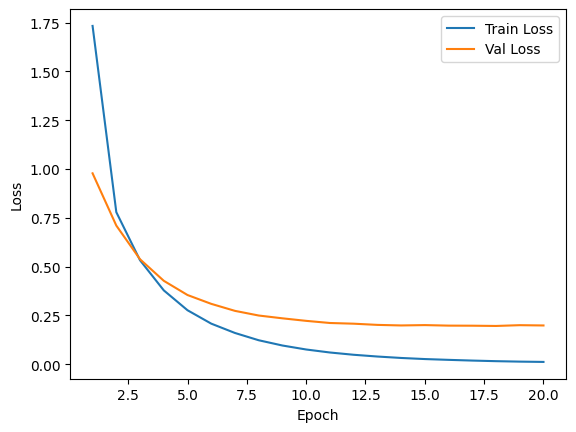

In [16]:
# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
# Прогнозирование на тестовом наборе
predictions = []
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

print(balanced_accuracy_score(test_labels, predictions))
print(precision_recall_fscore_support(test_labels, predictions, average = 'weighted'))

0.7595256520920489
(0.95610134509388, 0.9591836734693877, 0.9569451104311543, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# # Построение confusion matrix
# labels = data['intent'].unique()  # получите уникальные метки классов
# cm = confusion_matrix(test['intent'], predicted_intents, labels=labels)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.title(f'Logistic Regression')
# plt.show()

In [19]:
def plotCM(test, predictions, name:'str'):
    # Построение confusion matrix
    labels = test['intent'].unique()  # получите уникальные метки классов
    cm = confusion_matrix(test['intent'], predictions, labels=labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'{name}')
    plt.show()

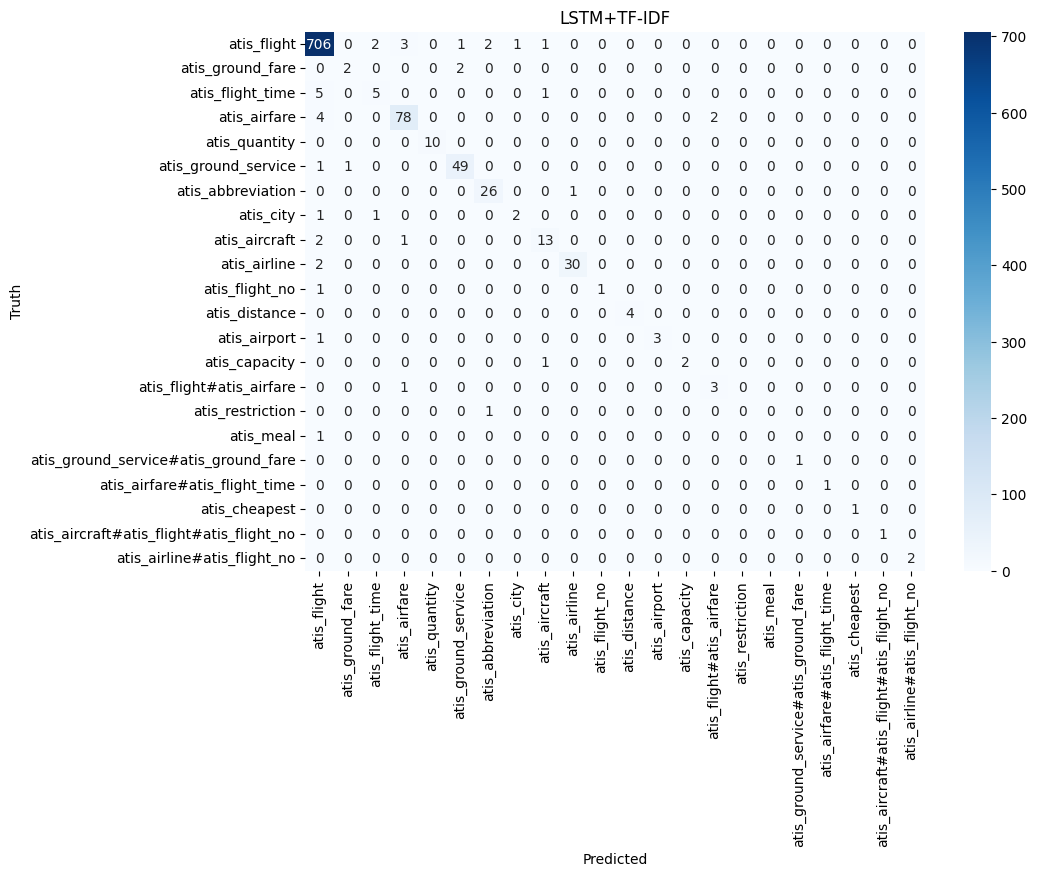

In [20]:
plotCM(test, predicted_intents,'LSTM+TF-IDF')

sentence-transformers/all-MiniLM-L6-v2

In [21]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [22]:
# Создание пользовательского Dataset класса
class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]
    
# Определение модели LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x.unsqueeze(1))
        out = self.fc(hn[-1])
        return out

In [23]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [24]:
# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Extract embeddings
with torch.no_grad():
    train_embeddings = model(**train_encodings).pooler_output
    test_embeddings = model(**test_encodings).pooler_output

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [25]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25


100%|██████████| 31/31 [00:00<00:00, 557.70it/s]


Epoch 1, Train Loss: 1.3593536660832874, Val Loss: 1.035337148174163


100%|██████████| 31/31 [00:00<00:00, 560.82it/s]


Epoch 2, Train Loss: 0.8176663336107286, Val Loss: 0.7012819580493435


100%|██████████| 31/31 [00:00<00:00, 577.65it/s]


Epoch 3, Train Loss: 0.5498439356432123, Val Loss: 0.5396507867882329


100%|██████████| 31/31 [00:00<00:00, 570.00it/s]


Epoch 4, Train Loss: 0.4363097557324474, Val Loss: 0.46846865309822944


100%|██████████| 31/31 [00:00<00:00, 576.59it/s]


Epoch 5, Train Loss: 0.36832862369463604, Val Loss: 0.4187278509620697


100%|██████████| 31/31 [00:00<00:00, 582.83it/s]


Epoch 6, Train Loss: 0.3232679679610972, Val Loss: 0.3913127736699197


100%|██████████| 31/31 [00:00<00:00, 593.09it/s]


Epoch 7, Train Loss: 0.2956798268261097, Val Loss: 0.36575645929382694


100%|██████████| 31/31 [00:00<00:00, 559.53it/s]


Epoch 8, Train Loss: 0.2687552675794242, Val Loss: 0.3469084395516303


100%|██████████| 31/31 [00:00<00:00, 430.12it/s]


Epoch 9, Train Loss: 0.24723522614498258, Val Loss: 0.33171074488951313


100%|██████████| 31/31 [00:00<00:00, 552.65it/s]


Epoch 10, Train Loss: 0.2313980951084424, Val Loss: 0.32767537392435536


100%|██████████| 31/31 [00:00<00:00, 565.27it/s]


Epoch 11, Train Loss: 0.21885058178045488, Val Loss: 0.3113529956148517


100%|██████████| 31/31 [00:00<00:00, 569.68it/s]


Epoch 12, Train Loss: 0.19827029323678905, Val Loss: 0.30628128746344196


100%|██████████| 31/31 [00:00<00:00, 582.88it/s]


Epoch 13, Train Loss: 0.18809731667703491, Val Loss: 0.2861917513993479


100%|██████████| 31/31 [00:00<00:00, 558.96it/s]


Epoch 14, Train Loss: 0.17595676160654275, Val Loss: 0.2805851342216615


100%|██████████| 31/31 [00:00<00:00, 575.88it/s]


Epoch 15, Train Loss: 0.16314200906998524, Val Loss: 0.26922294269165686


100%|██████████| 31/31 [00:00<00:00, 549.58it/s]


Epoch 16, Train Loss: 0.1574053447377884, Val Loss: 0.2619230520100363


100%|██████████| 31/31 [00:00<00:00, 437.83it/s]


Epoch 17, Train Loss: 0.1477138854531666, Val Loss: 0.25939685851335526


100%|██████████| 31/31 [00:00<00:00, 578.05it/s]


Epoch 18, Train Loss: 0.1404301896059917, Val Loss: 0.25086970939751596


100%|██████████| 31/31 [00:00<00:00, 569.81it/s]


Epoch 19, Train Loss: 0.13292496067361306, Val Loss: 0.25510391677098887


100%|██████████| 31/31 [00:00<00:00, 536.09it/s]


Epoch 20, Train Loss: 0.12188702423946332, Val Loss: 0.2477159444843569


100%|██████████| 31/31 [00:00<00:00, 564.31it/s]


Epoch 21, Train Loss: 0.11487400472574567, Val Loss: 0.24013496418633767


100%|██████████| 31/31 [00:00<00:00, 573.86it/s]


Epoch 22, Train Loss: 0.1111949146804163, Val Loss: 0.23369608855535906


100%|██████████| 31/31 [00:00<00:00, 592.56it/s]


Epoch 23, Train Loss: 0.10565748332478737, Val Loss: 0.2394276869393164


100%|██████████| 31/31 [00:00<00:00, 581.84it/s]


Epoch 24, Train Loss: 0.10301033324577798, Val Loss: 0.23738977589434193


100%|██████████| 31/31 [00:00<00:00, 518.48it/s]


Epoch 25, Train Loss: 0.09635709734412573, Val Loss: 0.23325104867258378


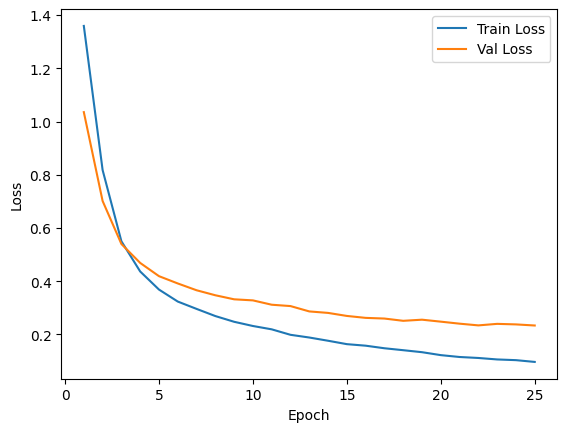

In [26]:
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# Прогнозирование на тестовом наборе
predictions = []
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

precision_recall_fscore weighted (0.9367137078528049, 0.9428571428571428, 0.935470783793191, None)
balanced_accuracy 0.5602259763463383


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


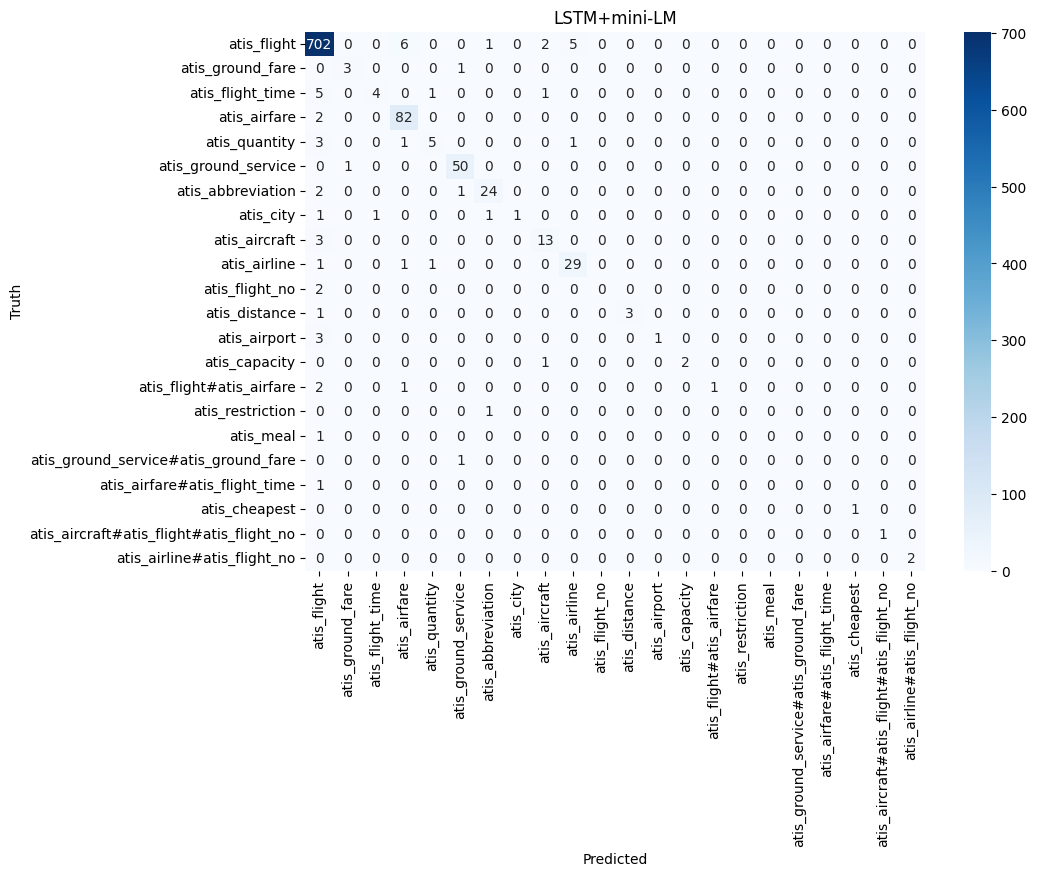

In [28]:
plotCM(test, predicted_intents, 'LSTM+mini-LM')

M-USE

In [29]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")
model = AutoModel.from_pretrained("sadakmed/distiluse-base-multilingual-cased-v2")

tokenizer_config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/539M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [30]:
# Tokenize and encode the text data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, return_tensors="pt")

# Извлечение эмбеддингов
with torch.no_grad():
    train_embeddings = model(**train_encodings).last_hidden_state.mean(dim=1)
    test_embeddings = model(**test_encodings).last_hidden_state.mean(dim=1)

le = LabelEncoder()

# Преобразование меток в числовые значения
train_labels = le.fit_transform(train['intent'])
test_labels = le.transform(test['intent'])


# Преобразование массивов numpy в тензоры PyTorch перед передачей в TextDataset
train_dataset = TextDataset(train_embeddings, torch.tensor(train_labels))
test_dataset = TextDataset(test_embeddings, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [31]:
# Создание и обучение модели
model = LSTMClassifier(input_dim=train_embeddings.shape[1], hidden_dim=256, output_dim=len(le.classes_))

# Перемещение модели на GPU, если он доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

n_epoches = 25

100%|██████████| 31/31 [00:00<00:00, 433.84it/s]


Epoch 1, Train Loss: 1.158728227271872, Val Loss: 0.8014983775154236


100%|██████████| 31/31 [00:00<00:00, 466.85it/s]


Epoch 2, Train Loss: 0.5631656653042567, Val Loss: 0.521466018211457


100%|██████████| 31/31 [00:00<00:00, 463.45it/s]


Epoch 3, Train Loss: 0.39222508062750605, Val Loss: 0.40764105560318115


100%|██████████| 31/31 [00:00<00:00, 474.73it/s]


Epoch 4, Train Loss: 0.2931223825504214, Val Loss: 0.3517442963296367


100%|██████████| 31/31 [00:00<00:00, 436.01it/s]


Epoch 5, Train Loss: 0.2288714201994619, Val Loss: 0.2812828164427511


100%|██████████| 31/31 [00:00<00:00, 477.73it/s]


Epoch 6, Train Loss: 0.18278927894277594, Val Loss: 0.24483480472718516


100%|██████████| 31/31 [00:00<00:00, 453.97it/s]


Epoch 7, Train Loss: 0.1486616202914235, Val Loss: 0.2202732153236866


100%|██████████| 31/31 [00:00<00:00, 466.04it/s]


Epoch 8, Train Loss: 0.12483750677557062, Val Loss: 0.20232777537838106


100%|██████████| 31/31 [00:00<00:00, 457.85it/s]


Epoch 9, Train Loss: 0.10712421669672101, Val Loss: 0.2345991548030607


100%|██████████| 31/31 [00:00<00:00, 437.69it/s]


Epoch 10, Train Loss: 0.09971466525536725, Val Loss: 0.18376641792635764


100%|██████████| 31/31 [00:00<00:00, 452.23it/s]


Epoch 11, Train Loss: 0.08533106966859709, Val Loss: 0.23309623582228536


100%|██████████| 31/31 [00:00<00:00, 460.55it/s]


Epoch 12, Train Loss: 0.07232523423824776, Val Loss: 0.1783473284975175


100%|██████████| 31/31 [00:00<00:00, 464.89it/s]


Epoch 13, Train Loss: 0.0600027846551295, Val Loss: 0.1668665442135065


100%|██████████| 31/31 [00:00<00:00, 471.91it/s]


Epoch 14, Train Loss: 0.06335412972938206, Val Loss: 0.15217947136730917


100%|██████████| 31/31 [00:00<00:00, 474.71it/s]


Epoch 15, Train Loss: 0.04743938697738794, Val Loss: 0.15378726514116411


100%|██████████| 31/31 [00:00<00:00, 319.97it/s]


Epoch 16, Train Loss: 0.04233293196431093, Val Loss: 0.1501278375545817


100%|██████████| 31/31 [00:00<00:00, 476.13it/s]


Epoch 17, Train Loss: 0.03872992023845377, Val Loss: 0.16492956816669432


100%|██████████| 31/31 [00:00<00:00, 467.66it/s]


Epoch 18, Train Loss: 0.034685944295804, Val Loss: 0.15568358643401053


100%|██████████| 31/31 [00:00<00:00, 462.34it/s]


Epoch 19, Train Loss: 0.03086378067826568, Val Loss: 0.16152139320488898


100%|██████████| 31/31 [00:00<00:00, 452.95it/s]


Epoch 20, Train Loss: 0.028534151414425064, Val Loss: 0.17618481838895428


100%|██████████| 31/31 [00:00<00:00, 466.18it/s]


Epoch 21, Train Loss: 0.026829117680189467, Val Loss: 0.19847915676091948


100%|██████████| 31/31 [00:00<00:00, 461.51it/s]


Epoch 22, Train Loss: 0.02162989521580669, Val Loss: 0.16402126004498813


100%|██████████| 31/31 [00:00<00:00, 472.87it/s]


Epoch 23, Train Loss: 0.020114488387677692, Val Loss: 0.18034905669910292


100%|██████████| 31/31 [00:00<00:00, 475.10it/s]


Epoch 24, Train Loss: 0.019237558494550885, Val Loss: 0.17118748361545225


100%|██████████| 31/31 [00:00<00:00, 479.82it/s]


Epoch 25, Train Loss: 0.017162657706895686, Val Loss: 0.16318798188360467


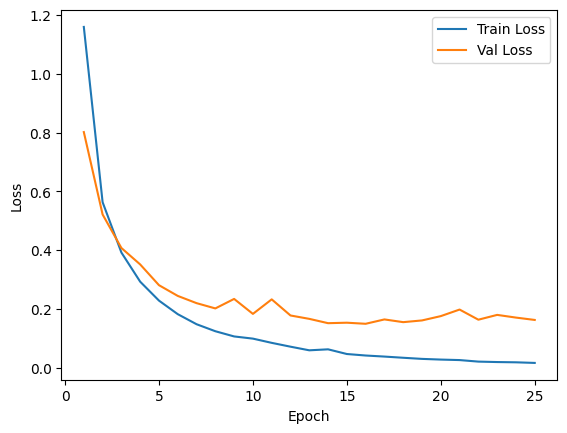

In [32]:
for epoch in range(n_epoches):
    train_loss = 0
    val_loss = 0
    # Обучение
    model.train()
    for texts, labels in tqdm(train_loader):
        # Перемещение данных на тот же устройство, что и модель
        texts = texts.float().to(device)
        labels = labels.to(device)

        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация
    model.eval()
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            texts = texts.float().to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Построение графика потерь
plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
# Прогнозирование на тестовом наборе
predictions = []
with torch.no_grad():
    for i, (input_ids, labels) in enumerate(test_loader):
        input_ids = input_ids.float().to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Перевод меток обратно в исходные интенты
predicted_intents = le.inverse_transform(predictions)

print("precision_recall_fscore weighted", precision_recall_fscore_support(test['intent'], predicted_intents, average='weighted'))
print("balanced_accuracy", balanced_accuracy_score(test['intent'], predicted_intents))

precision_recall_fscore weighted (0.9653067742776553, 0.960204081632653, 0.9613058001074871, None)
balanced_accuracy 0.8860477804169361


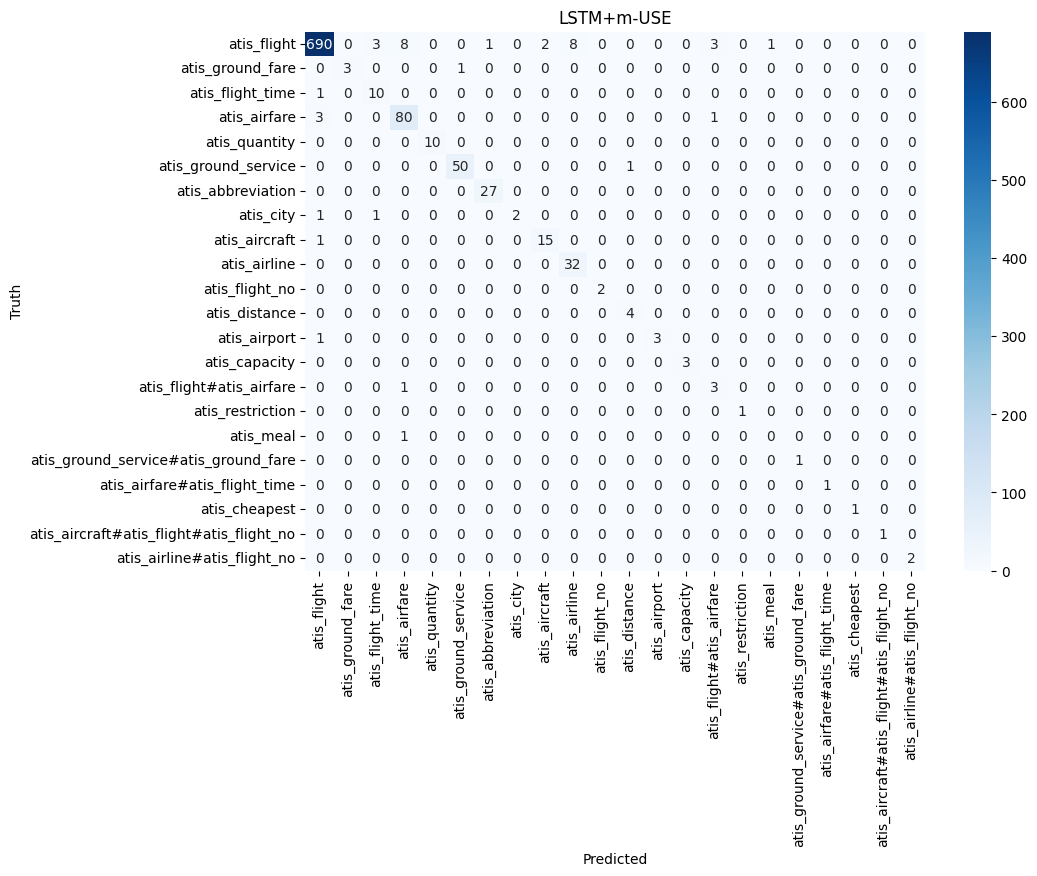

In [34]:
plotCM(test, predicted_intents, 'LSTM+m-USE')